# Create a wetland type map

### Background
This notebook can be used to generate wetland type map over a region defined by a vector.


In [1]:
%matplotlib inline

import os
import re
import json
import time
import random
import rasterio
import datacube
import warnings
import subprocess
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray as rxr
from IPython.display import clear_output
import matplotlib.pyplot as plt
from joblib import load
from odc.algo import xr_geomedian
from odc.dscache.tools import tiling
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap,BoundaryNorm
from datacube.utils import geometry
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from datacube.utils.geometry import BoundingBox, Geometry
from deafrica_tools.spatial import xr_rasterize
from datacube.testutils.io import rio_slurp_xarray
from deafrica_tools.classification import predict_xr
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.areaofinterest import define_area


## Create Dask cluster for running predictions
We use dask to parallel and speed up processing

In [2]:
# Set up a dask cluster
create_local_dask_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/8787/status,
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 97.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38177,Workers: 1
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 97.21 GiB
Comm: tcp://127.0.0.1:46281,Total threads: 15
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/35569/status,Memory: 97.21 GiB
Nanny: tcp://127.0.0.1:35285,


In [3]:
dc = datacube.Datacube(app='wetland_classification')

## Load the model 
We use the model trained and saved in the [Train_Classification_Algorithm](04_Train_Classification_Algorithm.ipynb).

### Load area of interest (AOI)

In [4]:
prefix = 'Rwanda'  # Specify the desired prefix - name of area of interest (aoi) is best to ensure the files have the aoi prefix when saved

# Method 1: Specify the latitude, longitude, and buffer
# aoi = define_area(lat=-1.8948, lon=29.9213, buffer=0.1)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
aoi = define_area(vector_path="data/rwanda.geojson")

#Create a geopolygon and geodataframe of the area of interest
geom = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geom_gdf = gpd.GeoDataFrame(geometry=[geom], crs=geom.crs)

In [5]:
# Get the latitude and longitude range of the geopolygon
lat_range = (geom_gdf.total_bounds[1], geom_gdf.total_bounds[3])
lon_range = (geom_gdf.total_bounds[0], geom_gdf.total_bounds[2])
display_map(x=lon_range, y=lat_range)

In [6]:
# Check if both binary and type models are available
if os.path.exists(f'results/{prefix}_Binary_RF_model.joblib') and os.path.exists(f'results/{prefix}_Type_RF_model.joblib'):
    binary_model = load(f'results/{prefix}_Binary_RF_model.joblib').set_params(n_jobs=1)
    print('Loaded binary random forest model:\n', binary_model)

    type_model = load(f'results/{prefix}_Type_RF_model.joblib').set_params(n_jobs=1)
    print('Loaded type random forest model:\n', type_model)
elif os.path.exists(f'results/{prefix}_Binary_RF_model.joblib'):
    binary_model = load(f'results/{prefix}_Binary_RF_model.joblib').set_params(n_jobs=1)
    print('Loaded binary random forest model:\n', binary_model)
elif os.path.exists(f'results/{prefix}_Type_RF_model.joblib'):
    type_model = load(f'results/{prefix}_Type_RF_model.joblib').set_params(n_jobs=1)
    print('Loaded type random forest model:\n', type_model)
else:
    print("No trained models found.")


Loaded binary random forest model:
 RandomForestClassifier(n_estimators=50, n_jobs=1, random_state=1)
Loaded type random forest model:
 RandomForestClassifier(n_jobs=1, random_state=1)


In [7]:
# Define the file paths for importing the feature names
binary_features_path = f"results/{prefix}_binary_model_features.json"
type_features_path = f"results/{prefix}_type_model_features.json"

# Load binary model feature names from JSON if binary model exists
if os.path.exists(binary_features_path):
    with open(binary_features_path, "r") as binary_file:
        binary_features_dict = json.load(binary_file)
    binary_feature_names = binary_features_dict["features"]
    print("Loaded binary model features.")
else:
    print("No binary model features found.")

# Load type model feature names from JSON if type model exists
if os.path.exists(type_features_path):
    with open(type_features_path, "r") as type_file:
        type_features_dict = json.load(type_file)
    type_feature_names = type_features_dict["features"]
    print("Loaded type model features.")
else:
    print("No type model features found.")


Loaded binary model features.
Loaded type model features.


### Break area of interest into tiles for smaller processing chunks

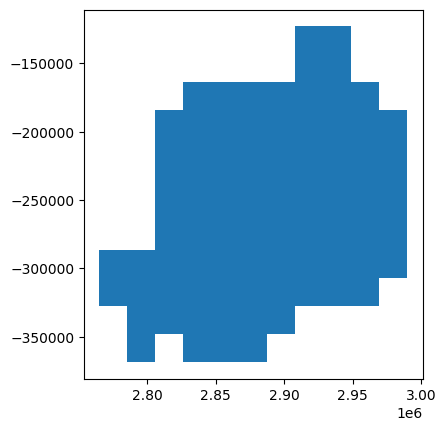

In [8]:
# Create a gridspec from string and convert to geoms
tiles = tiling.parse_gridspec(s="epsg:6933;20;1024")
tiles.tile_coords(tile_index=(0, 0))
tiles = tiles.tiles_from_geopolygon(geom)
geoms = (i[1].extent.geom for i in tiles)

geoms_df = gpd.GeoDataFrame(geometry=list(geoms))

# Set the CRS to EPSG:6933
geoms_df.crs = "EPSG:6933"

geoms_df.to_file(f"data/{prefix}_tiles.geojson", driver="GeoJSON")

# Plot the geometries
geoms_df.plot()

# Display the plot
plt.show()


## Create the query for running the predictions

We use the query saved from the feature extraction notebook to ensure data from the same periods are retrieved. However, only selected features will be used. 

> We add `dask_chunks` to the query parameter so the data will be lazy-loaded and only the features used by the model will be calculated.

In [9]:
time = ('2022')
# using nine spectral bands with 10~20 m spatial resolution
resolution = (-20,20)
output_crs='epsg:6933'

def feature_layers(query):
    # connect to the datacube
#     dc = datacube.Datacube(app='feature_layers')
    
    # load s2 annual geomedian
    ds = dc.load(
        product='gm_s2_annual',
        measurements = ['blue','green','red','red_edge_1','red_edge_2', 'red_edge_3','nir_1','nir_2','swir_1','swir_2','emad','smad','bcmad'],
        **query)
    
    # calculate some band indices
    ds = calculate_indices(ds,
                           index=['NDVI', 'MNDWI','TCW'],
                           drop=False,
                           satellite_mission='s2')
    
    
    # Add a prefix "Annual" to the band names
    new_band_names = ['Annual_' + band_name for band_name in ds.data_vars]
    ds = ds.rename({old_band_name: new_band_name for old_band_name, new_band_name in zip(ds.data_vars, new_band_names)})

    # stack multi-temporal measurements and rename them
    n_time = ds.dims['time']
    list_measurements = list(ds.keys())
    list_stack_measures = []
    for j in range(len(list_measurements)):
        for k in range(n_time):
            variable_name = list_measurements[j]+'_'+str(k)
            measure_single = ds[list_measurements[j]].isel(time=k).rename(variable_name)
            list_stack_measures.append(measure_single)
    ds_stacked = xr.merge(list_stack_measures, compat='override')

    
    # Load the Sentinel-1 data    
    ds_s1 = dc.load(product=["s1_rtc"],
                  measurements=['vv', 'vh'],
                  group_by="solar_day",
                  **query
                 )
    # Add a prefix "Sent1_" to the variables in ds_s1
    ds_s1 = ds_s1.rename({old_var: 'sent1_' + old_var for old_var in ds_s1.data_vars})

    # median values are used to scale the measurements so they have a similar range for visualization
    med_s1 = ds_s1[['sent1_vv','sent1_vh']].median(dim='time')
    
    # Add ALOS L-Band Annual mosaic
    ds_alos = dc.load(product='alos_palsar_mosaic',
                      measurements=['hh','hv'],
                      **query)
    
    # Add a prefix "Sent1_" to the variables in ds_s1
    ds_alos = ds_alos.rename({old_var: 'alos_' + old_var for old_var in ds_alos.data_vars})
        
    med_alos = ds_alos[['alos_hh','alos_hv']].median(dim='time')
    

    # Add WOfS Annual summary
    wofs_annual = dc.load(product='wofs_ls_summary_annual',
               like=ds.geobox,
               time=query['time'])
    wofs_annual_frequency = wofs_annual.frequency
    wofs_annual_frequency.name = 'WOfS_annual_frequency'
    
    
    # loop through the terrain attribite files and add them to the dataset
    folder = os.path.join("data/terrain_attributes/", prefix)
    for filename in os.listdir(folder):
            if filename.endswith('.tif'):
                filepath = os.path.join(folder, filename)
                tif = rio_slurp_xarray(filepath, gbox=ds.geobox)
                tif = tif.to_dataset(name=filename.replace('.tif', ''))
                ds_stacked = xr.merge([ds_stacked, tif], compat='override')


    # merge all the datasets into a single dataset
    ds_stacked = xr.merge([ds_stacked, med_s1, med_alos, wofs_annual_frequency], compat='override')

    return ds_stacked

## Apply classification model to predict wetlands in the AOI

The model will be applied over each tile, producing a prediction map and a probabilities map. The maps are saved as Cloud-Optimized Geotiffs (COGs).

> Tiles are processed in sequence. For each tile, the processing needs to fit into the compute resources available in the sandbox. Make the tile size smaller if you run out of memory. For production of a map over a large region or country, consider applying for [a large sandbox (with more CPUs and momery)](
https://helpdesk.digitalearthafrica.org/portal/en/community/topic/call-for-application-for-access-to-large-sandboxes-15-processing-cores-and-120-gb-of-memory)

In [10]:
skip_existing = False
output_folder = "results"
binary_tiles_pred_folder = os.path.join(output_folder, f"{prefix}/binary_tiles_predicted")
os.makedirs(binary_tiles_pred_folder, exist_ok=True)

## Binary classification
#### Binary predictions and probabilities per tile

In [ ]:
predictions = []
dask_chunks = {'x':2500,'y':2500}

# generate a datacube query object
query = {
    'geopolygon': geom,
    'time': time,
    'resolution': resolution,
    'output_crs': output_crs,
    'dask_chunks': dask_chunks,
}

for index in range(len(geoms_df)):   # Iterate over the tiles
    aoi = geoms_df.iloc[index]
#     print(f"Processing Polygon {index + 1} of {len(geoms_df)}")
    progress_text = f"Predicting... Polygon {index + 1} of {len(geoms_df)}"
    print(progress_text)
    
    # Check if polygon has already been processed. If so, skip
    output_filename = os.path.join(
        binary_tiles_pred_folder, f"{prefix}_tile{index:03d}_wetland_binary_prediction.tif")
    probabilities_filename = os.path.join(
        binary_tiles_pred_folder, f"{prefix}_tile{index:03d}_wetland_binary_probabilities.tif")
    if skip_existing and os.path.exists(output_filename) and os.path.exists(probabilities_filename):
        print("Completed; Skipping")
        continue

    # set up query based on aoi geometry
    geom = geometry.Geometry(geom=aoi.geometry, crs=geoms_df.crs)
    query.update({"geopolygon": geom})
    
    # calculate features
    data = feature_layers(query).persist()
    
    # Only keep features that are in the original list of columns
    data = data[binary_feature_names]

    # Convert xarray Dataset object to Dask array
    data_dask = data.chunk(dask_chunks)

    # predict using the imported model
    predicted = predict_xr(binary_model,
                           data_dask,
                           proba=True,
                           persist=True,
                           clean=True,
                           return_input=True
                           ).compute().persist()
    
    # Create a mask for the aoi
    print("    Getting AOI mask")
    aoi_mask = xr_rasterize(
        gdf=gpd.GeoDataFrame({"Polygon": [index], "geometry": [
                             aoi.geometry]}, crs=geoms_df.crs),
        da=predicted,
        crs=output_crs,
    )

    # set the no data value
    NODATA = 255

    # Mask the predictions
    print("    Preparing predictions")
    predicted_masked = (
        predicted.Predictions.where(aoi_mask == 1, NODATA)
    )
    predicted_masked.attrs["nodata"] = NODATA

    # Write predictions to COG
    print(f"    Writing predictions to {output_filename}")
    write_cog(
        predicted_masked,
        fname=output_filename,
        overwrite=True,
        nodata=255,
    )

    del predicted_masked

    # Mask the probabilities
    probability_masked = (
        predicted.Probabilities.where(aoi_mask == 1, NODATA)
    )
    probability_masked.attrs["nodata"] = NODATA

    print(f"    Writing probabilities to {probabilities_filename}")
    write_cog(
        probability_masked,
        fname=probabilities_filename,
        overwrite=True,
        nodata=255,
    )


    del probability_masked

    del aoi_mask
    
    # Clear the output
    clear_output(wait=True)

Predicting... Polygon 4 of 87
predicting...


#### Merge the tiles and export the final wetland predictions and probabilities

In [ ]:
# skip_existing = False

# Get the list of files in the tiles_pred folder
tile_files = os.listdir(binary_tiles_pred_folder)

# Create a list to store the paths of prediction and probability files
prediction_files = []
probability_files = []

# Define the pattern for matching the filenames
pattern_prediction = fr"{prefix}_tile\d+_wetland_binary_prediction.tif"
pattern_probability = fr"{prefix}_tile\d+_wetland_binary_probabilities.tif"

# Compile the regular expression patterns
regex_prediction = re.compile(pattern_prediction)
regex_probability = re.compile(pattern_probability)

# Iterate over the tile files
for file in tile_files:
    # Check if the file is a prediction file
    if regex_prediction.match(file):
        prediction_files.append(os.path.join(binary_tiles_pred_folder, file))
    # Check if the file is a probability file
    elif regex_probability.match(file):
        probability_files.append(os.path.join(binary_tiles_pred_folder, file))

# Define the output mosaic filenames
out_mosaic_prediction = f"{output_folder}/{prefix}/{prefix}_merged_wetland_binary_prediction.tif"
out_mosaic_probabilities = f"{output_folder}/{prefix}/{prefix}_merged_wetland_binary_probabilities.tif"

# Remove the merged files if they already exist
if os.path.exists(out_mosaic_prediction):
    subprocess.run(f"rm {out_mosaic_prediction}", shell=True)

if os.path.exists(out_mosaic_probabilities):
    subprocess.run(f"rm {out_mosaic_probabilities}", shell=True)

# Merge the individual tiles into the merged files
merge_cmd_prediction = f"gdal_merge.py -o {out_mosaic_prediction} -co COMPRESS=Deflate -ot Byte {' '.join(prediction_files)} -init 255 -a_nodata 255"
subprocess.run(merge_cmd_prediction, shell=True)

merge_cmd_probabilities = f"gdal_merge.py -o {out_mosaic_probabilities} -co COMPRESS=Deflate -ot Byte {' '.join(probability_files)} -init 255 -a_nodata 255"
subprocess.run(merge_cmd_probabilities, shell=True)

# Load the merged predictions as xarray DataArray
merged_prediction = rxr.open_rasterio(out_mosaic_prediction).squeeze()
merged_probabilities = rxr.open_rasterio(out_mosaic_probabilities).squeeze()

# Rasterize the area of interest polygon
aoi_raster = xr_rasterize(gdf=geom_gdf,
                          da=merged_prediction,
                          crs=merged_prediction.rio.crs)


# Mask the wetland classes pixels within the AOI
binary_wetland_predictions = merged_prediction.where((~np.isnan(merged_prediction)) &
                                                      (aoi_raster != 0))

# Define the output clipped filenames
clipped_prediction_file = f"{output_folder}/{prefix}/{prefix}_wetland_binary_prediction.tif"
clipped_probabilities_file = f"{output_folder}/{prefix}/{prefix}_wetland_binary_probabilities.tif"

# Write the clipped wetland predictions to file
write_cog(
    binary_wetland_predictions,
    fname=clipped_prediction_file,
    overwrite=True,
    nodata=255,
)

# Clip the wetland probabilities to the AOI
binary_wetland_probabilities = merged_probabilities.where((~np.isnan(merged_prediction)) &
                                                      (aoi_raster != 0))

# Write the clipped wetland probabilities to file
write_cog(
    binary_wetland_probabilities,
    fname=clipped_probabilities_file,
    overwrite=True,
    nodata=255,
)

# Delete the merged files
if os.path.exists(out_mosaic_prediction):
    os.remove(out_mosaic_prediction)

if os.path.exists(out_mosaic_probabilities):
    os.remove(out_mosaic_probabilities)

#### Plot the wetland predicition and probabilities

In [ ]:
# Create a new label dictionary
labels_dict_binary = {'Non-wetland': 0, 'Wetland': 1}

# Generate random colors for each class (excluding class 0)
random.seed(42)  # Set a seed for reproducibility
class_colors = {class_name: f'#{random.randint(0, 255):02x}{random.randint(0, 255):02x}{random.randint(0, 255):02x}'
                for class_name in labels_dict_binary}

# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot wetland predictions
# Sort classes based on their numeric labels
sorted_classes = sorted(labels_dict_binary, key=lambda x: labels_dict_binary[x])

# Plot wetland predictions
cmap = ListedColormap([class_colors[class_name] for class_name in sorted_classes])
binary_wetland_predictions.plot.imshow(ax=axes[0],
                                cmap=cmap,
                                add_colorbar=False,
                                interpolation='none')
axes[0].set_title('Wetland Predictions', fontweight='bold')

# Plot clipped wetland probabilities
im = binary_wetland_probabilities.plot.imshow(ax=axes[1],
                                       cmap='RdYlBu',
                                       add_colorbar=False)
axes[1].set_title('Wetland Probabilities', fontweight='bold')

# Add legend to the first subplot
patches_list = [Patch(facecolor=class_colors[class_name]) for class_name in sorted_classes]
legend = axes[0].legend(patches_list, [class_name for class_name in sorted_classes],
                        loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust spacing
fig.tight_layout()

# Add colorbar outside the subplot
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.04)
cbar.set_label('Wetland Probability')

# Show the plot
plt.show()



### Independent accuaracy assessment 

In [ ]:
# Load the testing points GeoDataFrame
testing_points = gpd.read_file(f'data/{prefix}_testing_samples.geojson')

# Replace non-zero values in the 'class_id' column with 1
testing_points['class_id_binary'] = testing_points['class_id'].apply(lambda x: 1 if x != 0 else 0)
# Insert the new column at the second position
testing_points.insert(1, 'class_id_binary', testing_points.pop('class_id_binary'))

# Sample the predictions and probabilities at testing points
sampled_predictions = []
sampled_probabilities = []

for point in testing_points.geometry:
    # Extract the point coordinates
    x, y = point.x, point.y
    
    # Sample the binary predictions and probabilities at the point coordinates
    prediction = binary_wetland_predictions.sel(x=x, y=y, method='nearest').item()
    probability = binary_wetland_probabilities.sel(x=x, y=y, method='nearest').item()
    
    # Append the sampled values
    sampled_predictions.append(prediction)
    sampled_probabilities.append(probability)

# Add the sampled values as new columns in the GeoDataFrame
testing_points['sampled_predictions'] = sampled_predictions
testing_points['sampled_probabilities'] = sampled_probabilities

# Calculate the number of correctly classified samples
correct_count = (testing_points['sampled_predictions'] == testing_points['class_id_binary']).sum()

# Calculate the total number of samples
total_count = len(testing_points)

# Calculate the accuracy as a percentage
accuracy_percentage = (correct_count / total_count) * 100

# Print the accuracy percentage
print(f"Overall Accuracy: {accuracy_percentage:.2f}%")


## Wetland Type classification
#### Applied to the wetland class

In [ ]:
 # Check if type_model exists
if 'type_model' in locals():   
    tiles_pred_folder = os.path.join(output_folder, f"{prefix}/type_tiles_predicted")
    os.makedirs(tiles_pred_folder, exist_ok=True)

    predictions = []
    dask_chunks = {'x':2500,'y':2500}

    # generate a datacube query object
    query = {
        'geopolygon': geom,
        'time': time,
        'resolution': resolution,
        'output_crs': output_crs,
        'dask_chunks': dask_chunks,
    }

    for index in range(len(geoms_df)):   # Iterate over the tiles
        aoi = geoms_df.iloc[index]
    #     print(f"Processing Polygon {index + 1} of {len(geoms_df)}")
        progress_text = f"Predicting... Polygon {index + 1} of {len(geoms_df)}"
        print(progress_text)

        # Check if polygon has already been processed. If so, skip
        output_filename = os.path.join(
            tiles_pred_folder, f"{prefix}_tile{index:03d}_wetland_type_prediction.tif")
        probabilities_filename = os.path.join(
            tiles_pred_folder, f"{prefix}_tile{index:03d}_wetland_type_probabilities.tif")
        if skip_existing and os.path.exists(output_filename) and os.path.exists(probabilities_filename):
            print("Completed; Skipping")
            continue

        # set up query based on aoi geometry
        geom = geometry.Geometry(geom=aoi.geometry, crs=geoms_df.crs)
        query.update({"geopolygon": geom})

        # set the no data value
        NODATA = 255

        # calculate features
        data = feature_layers(query).persist()

        # Clip the data to the extent of wetland predictions
        data = data.where(binary_wetland_predictions == 1)

        # Only keep features that are in the original list of columns
        data = data[type_feature_names]

        # Convert xarray Dataset object to Dask array
        data_dask = data.chunk(dask_chunks)

        # predict using the imported model
        predicted = predict_xr(type_model,
                               data_dask,
                               proba=True,
                               persist=True,
                               clean=True,
                               return_input=True
                               ).compute().persist()

        # Create a mask for the aoi
        print("    Getting AOI mask")
        aoi_mask = xr_rasterize(
            gdf=gpd.GeoDataFrame({"Polygon": [index], "geometry": [
                                 aoi.geometry]}, crs=geoms_df.crs),
            da=predicted,
            crs=output_crs,
        )


        # Mask the predictions with both AOI mask and wetland predictions mask
        print("    Preparing predictions")
        predicted_masked = (
            predicted.Predictions.where((aoi_mask == 1) & (binary_wetland_predictions == 1), NODATA)
        )
        predicted_masked.attrs["nodata"] = NODATA

        # Write predictions to COG
        print(f"    Writing predictions to {output_filename}")
        write_cog(
            predicted_masked,
            fname=output_filename,
            overwrite=True,
            nodata=255,
        )

        del predicted_masked

        # Mask the probabilities with both AOI mask and wetland predictions mask
        probability_masked = (
            predicted.Probabilities.where((aoi_mask == 1) & (binary_wetland_predictions == 1), NODATA)
        )
        probability_masked.attrs["nodata"] = NODATA

        print(f"    Writing probabilities to {probabilities_filename}")
        write_cog(
            probability_masked,
            fname=probabilities_filename,
            overwrite=True,
            nodata=255,
        )

        del probability_masked


        del aoi_mask

        # Clear the output
        clear_output(wait=True)
else:
    print("Skipping prediction process as wetland type model is not available.")             

#### Merge the tiles and export the final wetland predicitons and probabilities

In [ ]:
# Check if type_model exists
if 'type_model' in locals():
    # Get the list of files in the tiles_pred folder
    tile_files = os.listdir(tiles_pred_folder)

    # Create a list to store the paths of prediction and probability files
    prediction_files = []
    probability_files = []

    # Define the pattern for matching the filenames
    pattern_prediction = fr"{prefix}_tile\d+_wetland_type_prediction.tif"
    pattern_probability = fr"{prefix}_tile\d+_wetland_type_probabilities.tif"

    # Compile the regular expression patterns
    regex_prediction = re.compile(pattern_prediction)
    regex_probability = re.compile(pattern_probability)

    # Iterate over the tile files
    for file in tile_files:
        # Check if the file is a prediction file
        if regex_prediction.match(file):
            prediction_files.append(os.path.join(tiles_pred_folder, file))
        # Check if the file is a probability file
        elif regex_probability.match(file):
            probability_files.append(os.path.join(tiles_pred_folder, file))

    # Define the output mosaic filenames
    out_mosaic_prediction = f"{output_folder}/{prefix}/{prefix}_merged_wetland_prediction.tif"
    out_mosaic_probabilities = f"{output_folder}/{prefix}/{prefix}_merged_wetland_probabilities.tif"

    # Remove the merged files if they already exist
    if os.path.exists(out_mosaic_prediction):
        subprocess.run(f"rm {out_mosaic_prediction}", shell=True)

    if os.path.exists(out_mosaic_probabilities):
        subprocess.run(f"rm {out_mosaic_probabilities}", shell=True)

    # Merge the individual tiles into the merged files
    merge_cmd_prediction = f"gdal_merge.py -o {out_mosaic_prediction} -co COMPRESS=Deflate -ot Byte {' '.join(prediction_files)} -init 255 -a_nodata 255"
    subprocess.run(merge_cmd_prediction, shell=True)

    merge_cmd_probabilities = f"gdal_merge.py -o {out_mosaic_probabilities} -co COMPRESS=Deflate -ot Byte {' '.join(probability_files)} -init 255 -a_nodata 255"
    subprocess.run(merge_cmd_probabilities, shell=True)

    # Load the merged predictions as xarray DataArray
    merged_prediction = rxr.open_rasterio(out_mosaic_prediction).squeeze()
    merged_probabilities = rxr.open_rasterio(out_mosaic_probabilities).squeeze()

    # Rasterize the area of interest polygon
    aoi_raster = xr_rasterize(gdf=geom_gdf,
                              da=merged_prediction,
                              crs=merged_prediction.rio.crs)


    # Mask the wetland classes pixels within the AOI
    wetland_type_predictions = merged_prediction.where((aoi_raster == 1) & (binary_wetland_predictions == 1))

    # Define the output clipped filenames
    clipped_prediction_file = f"{output_folder}/{prefix}/{prefix}_wetland_type_prediction.tif"
    clipped_probabilities_file = f"{output_folder}/{prefix}/{prefix}_wetland_type_probabilities.tif"

    # Write the clipped wetland predictions to file
    write_cog(
        wetland_type_predictions,
        fname=clipped_prediction_file,
        overwrite=True,
        nodata=255,
    )

    # Clip the wetland probabilities to the AOI
    wetland_type_probabilities = merged_probabilities.where((aoi_raster == 1) & (binary_wetland_predictions == 1))

    # Write the clipped wetland probabilities to file
    write_cog(
        wetland_type_probabilities,
        fname=clipped_probabilities_file,
        overwrite=True,
        nodata=255,
    )

    # Delete the merged files
    if os.path.exists(out_mosaic_prediction):
        os.remove(out_mosaic_prediction)

    if os.path.exists(out_mosaic_probabilities):
        os.remove(out_mosaic_probabilities)
        
else:
    print("Skipping merging and clipping process as wetland type model is not available.")        

#### Plot the wetland type predicitions and probabilities¶

In [ ]:
# Check if type_model exists
if 'type_model' in locals():
    # Import the class label dictionary
    with open(f'data/{prefix}_labels_dict.json', 'r') as json_file:
        labels_dict = json.load(json_file)
        # Remove the non-wetland class from the dictionary
        if 0 in labels_dict.values():
            del labels_dict['Non-wetland']    

    # Generate random colors for each class (excluding class 0)
    random.seed(42)  # Set a seed for reproducibility
    class_colors = {class_name: f'#{random.randint(0, 255):02x}{random.randint(0, 255):02x}{random.randint(0, 255):02x}'
                    for class_name in labels_dict}

    # Create the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot wetland predictions
    # Sort classes based on their numeric labels
    sorted_classes = sorted(labels_dict, key=lambda x: labels_dict[x])

    # Plot wetland predictions
    cmap = ListedColormap([class_colors[class_name] for class_name in sorted_classes])
    wetland_type_predictions.plot.imshow(ax=axes[0],
                                    cmap=cmap,
                                    add_colorbar=False,
                                    interpolation='none')
    axes[0].set_title('Wetland Predictions', fontweight='bold')

    # Plot clipped wetland probabilities
    im = wetland_type_probabilities.plot.imshow(ax=axes[1],
                                           cmap='RdYlBu',
                                           add_colorbar=False)
    axes[1].set_title('Wetland Probabilities', fontweight='bold')

    # Add legend to the first subplot
    patches_list = [Patch(facecolor=class_colors[class_name]) for class_name in sorted_classes]
    legend = axes[0].legend(patches_list, [class_name for class_name in sorted_classes],
                            loc='center left', bbox_to_anchor=(1, 0.5))
    # Adjust spacing
    fig.tight_layout()


    # Add colorbar outside the subplot
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.04)
    cbar.set_label('Wetland Probability')

    # Show the plot
    plt.show()
else:
    print("Skipping plotting process as wetland type model is not available.") 

### Independent accuaracy assessment 

In [ ]:
# Check if type_model exists
if 'type_model' in locals():
# Load the testing points GeoDataFrame
    testing_points = gpd.read_file(f'data/{prefix}_testing_samples.geojson')

    # Sample the predictions and probabilities at testing points
    sampled_predictions = []
    sampled_probabilities = []

    for point in testing_points.geometry:
        # Extract the point coordinates
        x, y = point.x, point.y

        # Sample the binary predictions at the point coordinates
        prediction = wetland_type_predictions.sel(x=x, y=y, method='nearest').item()

        # Append the sampled values
        sampled_predictions.append(prediction)

    # Add the sampled values as new columns in the GeoDataFrame
    testing_points['sampled_predictions'] = sampled_predictions

    # Calculate the number of correctly classified samples
    correct_count = (testing_points['sampled_predictions'] == testing_points['class_id']).sum()

    # Calculate the total number of samples
    total_count = len(testing_points)

    # Calculate the accuracy as a percentage
    accuracy_percentage = (correct_count / total_count) * 100

    # Print the accuracy percentage
    print(f"Overall Accuracy: {accuracy_percentage:.2f}%")
else:
    print("Skipping paccuracy calculation as wetland type model is not available.") 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')